<a href="https://colab.research.google.com/github/Abhishekjain113/Abhishekjain113/blob/main/densenet_121_covide_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os

#required libraries
import cv2
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121



In [4]:
disease_types=['COVID', 'non-COVID']
data_dir = '//content/drive/MyDrive/Internship/Dataset'
train_dir = os.path.join(data_dir)

In [5]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1197).png,0,COVID
1,COVID/Covid (1252).png,0,COVID
2,COVID/Covid (132).png,0,COVID
3,COVID/Covid (124).png,0,COVID
4,COVID/Covid (1228).png,0,COVID


In [6]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (3).png,0,COVID
1,COVID/Covid (661).png,0,COVID
2,non-COVID/Non-Covid (51).png,1,non-COVID
3,non-COVID/Non-Covid (575).png,1,non-COVID
4,COVID/Covid (854).png,0,COVID


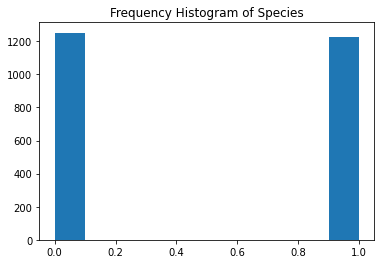

<Figure size 864x864 with 0 Axes>

In [7]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

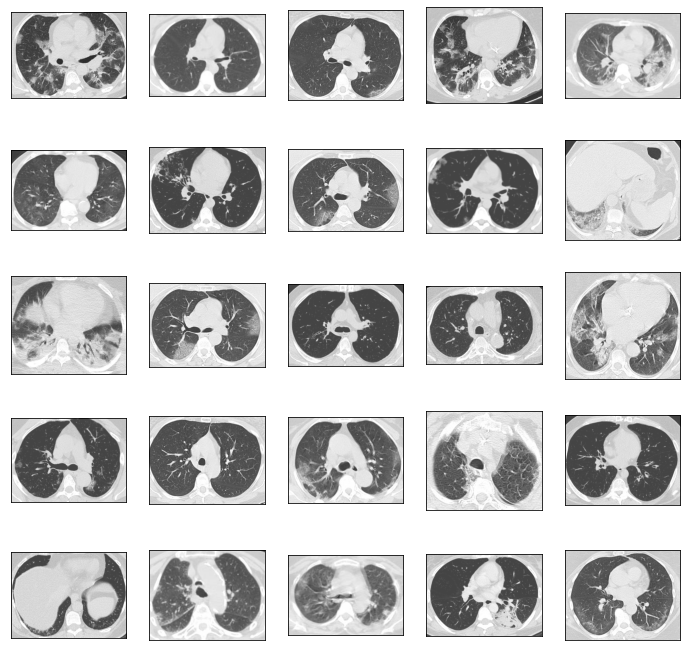

In [8]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('COVID', 5, 5)

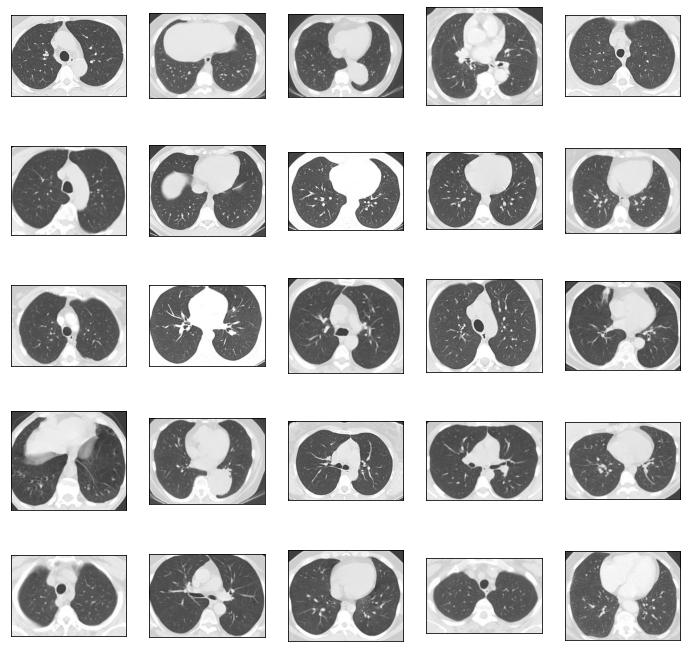

In [9]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('non-COVID', 5, 5)

In [10]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [11]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2481it [04:09,  9.96it/s]


Train Shape: (2481, 64, 64, 3)


In [12]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [13]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

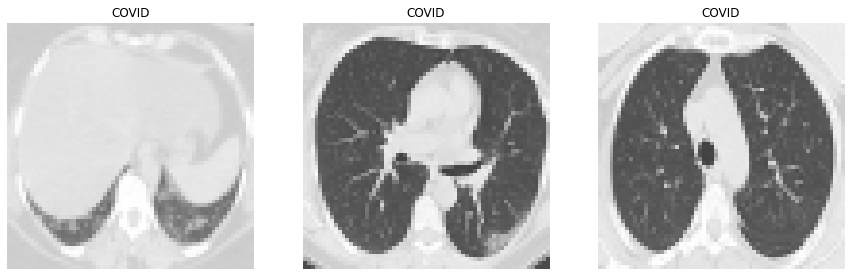

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [15]:
EPOCHS = 25
SIZE=64
N_ch=3

In [16]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [17]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                              

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-17-716925b5d11f>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


Epoch 1/25

Epoch 1: val_loss improved from inf to 1.74355, saving model to model.h5
31/31 - 32s - loss: 1.1804 - accuracy: 0.5459 - val_loss: 1.7435 - val_accuracy: 0.4487 - lr: 0.0020 - 32s/epoch - 1s/step
Epoch 2/25

Epoch 2: val_loss improved from 1.74355 to 1.29017, saving model to model.h5
31/31 - 5s - loss: 0.9971 - accuracy: 0.6255 - val_loss: 1.2902 - val_accuracy: 0.4547 - lr: 0.0020 - 5s/epoch - 151ms/step
Epoch 3/25

Epoch 3: val_loss improved from 1.29017 to 0.80229, saving model to model.h5
31/31 - 6s - loss: 0.9520 - accuracy: 0.6467 - val_loss: 0.8023 - val_accuracy: 0.5392 - lr: 0.0020 - 6s/epoch - 197ms/step
Epoch 4/25

Epoch 4: val_loss did not improve from 0.80229
31/31 - 4s - loss: 0.8471 - accuracy: 0.6784 - val_loss: 0.8031 - val_accuracy: 0.5775 - lr: 0.0020 - 4s/epoch - 116ms/step
Epoch 5/25

Epoch 5: val_loss did not improve from 0.80229
31/31 - 4s - loss: 0.7180 - accuracy: 0.6971 - val_loss: 0.9751 - val_accuracy: 0.5594 - lr: 0.0020 - 4s/epoch - 114ms/step


In [18]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 1s 31ms/step - loss: 0.4030 - accuracy: 0.8089
Final Loss: 0.4029911756515503, Final Accuracy: 0.8088530898094177


16/16 [==============================] - 3s 25ms/step


Text(0.5, 145.31999999999996, 'Predicted')

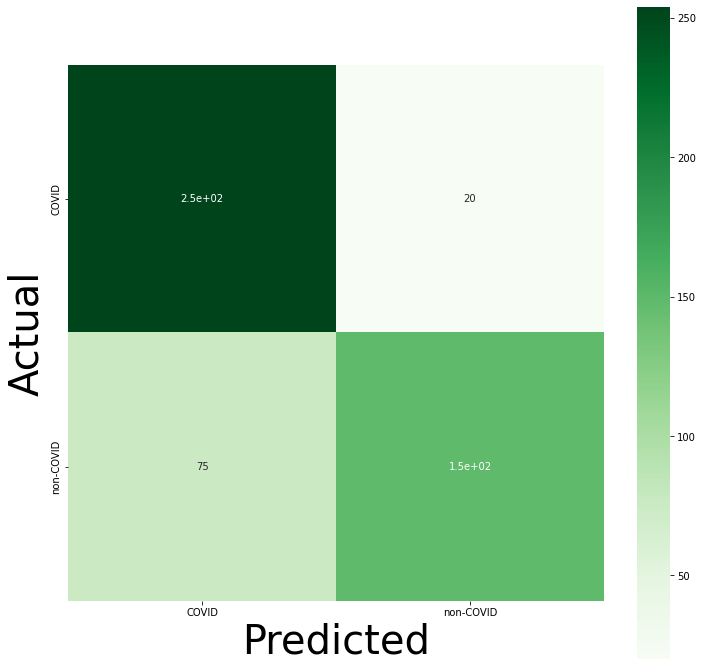

In [19]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

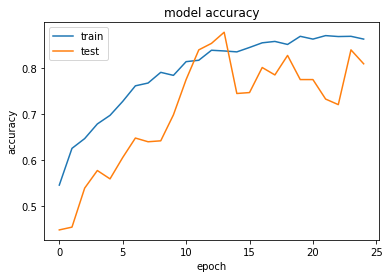

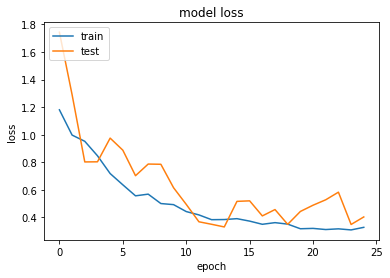

In [20]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 723ms/step
[9.9999714e-01 2.8549082e-06]


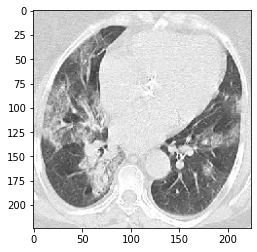

Prediction: Covid-19


In [21]:
from skimage import io
#path='imbalanced/Scratch/Scratch_400.jpg'
import keras.utils as image

img = image.load_img('//content/drive/MyDrive/Internship/Dataset/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('//content/drive/MyDrive/Internship/Dataset/COVID/Covid (1010).png', grayscale=False, target_size=(224, 224))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

# New Section